In [88]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(3,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [91]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

IsADirectoryError: [Errno 21] Is a directory: 'mock_data/.ipynb_checkpoints'

4.8843756333752095e-06

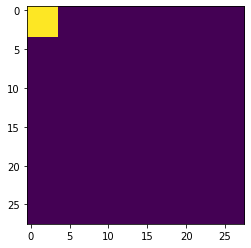

In [89]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
plt.imshow(images[1100])
circuit,image_re=run_part1(images[1100])
plt.imshow(image_re)
image_mse(images[1100], image_re)

In [90]:
image_mse(np.array([0.00000000001, 0.000000000001]), np.array([0.00000005, 0.00000023]))

2.76992700505e-14

In [91]:
from math import acos, floor, sqrt
#submission to part 1, you should make this into a .py file

#n=len(dataset)
mse=0
gatecount=0

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    aim = np.zeros((7,7))
    for x in range(7):
        for y in range(7):
            avg_val = 0
            counter = 0
            for l in range(4):
                for k in range(4):
                    avg_val += image[4*x+l][4*y+k]
                    counter += 1
            aim[x][y] = avg_val / counter

    num_qubits = 16
    q = qiskit.QuantumRegister(num_qubits)
    circuit = qiskit.QuantumCircuit(q)
    
    im = aim.flatten()[:-1]
    
    should_continue = True
    
    for i in range(num_qubits):
        pixel, im = im[0], im[1:]
        circuit.rx(acos(pixel)*2, i)
        pixel, im = im[0], im[1:]
        circuit.rz(acos(pixel)*2, i)
        pixel, im = im[0], im[1:]
        circuit.rx(acos(pixel)*2, i)
    return circuit

def decode(histogram):
    return np.zeros((28,28))

def run_part1(image):
    #encode image into a circuit
    circuit=encode(image)

    #simulate circuit
    histogram=simulate(circuit)

    #reconstruct the image
    image_re=decode(histogram)

    return circuit,image_re

In [97]:
#how we grade your submission

#n=len(dataset)
mse=0
gatecount=0
f = 0
for im in images:
    #encode image into circuit
    circuit,image_re=run_part1(im)
    
    #count the number of 2qubit gates used
    gate_count = count_gates(circuit)[2]
    gatecount+=gate_count
    #calculate mse
    im_mse = image_mse(im,image_re)
    mse+=im_mse
    f += 1-im_mse
#fidelity of reconstruction
f=f/len(images)
gatecount=gatecount/len(images)

#score for part1 
print(f)
print(f*(0.999**gatecount))

0.9999962214291951
0.9999962214291951


In [93]:
im = images[1]

def smooth(i):
    aim = np.zeros((28,28))
    for x in range(7):
        for y in range(7):
            max_val = -1
            avg_val = 0
            counter = 0
            for l in range(4):
                for k in range(4):
                    avg_val += i[4*x+l][4*y+k]
                    counter += 1
            for l in range(4):
                for k in range(4):
                        aim[4*x+l][4*y+k] = avg_val / counter
    return aim

In [94]:
im = images[1100]
1-image_mse(im, smooth(im))

0.9999994561202254

In [41]:
print(smooth(im)[20][20], smooth(im)[22][22], smooth(im)[23][22], smooth(im)[22][23], smooth(im)[24][24])

0.00035851595540176855 0.00035851595540176855 0.00035851595540176855 0.00035851595540176855 0.0


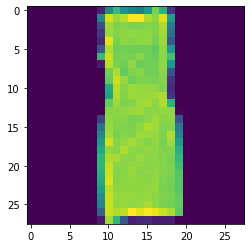

In [44]:
plt.imshow(images[1100])


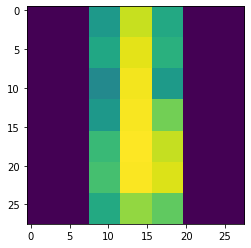

In [45]:
plt.imshow(smooth(im))


In [87]:
avg = 0
for im in images:
    avg += 1 - image_mse(im, np.zeros((28,28)))
a = avg / len(images)
a

0.9999962214291951